In [1]:
import csoundengine as ce

In [1]:
from csoundengine import OfflineEngine
e = OfflineEngine()

--Csound version 7.0 (double samples) Feb 14 2025
[commit: f0bf77568df31b2ade4fe7fce654a5e6af5e8e45]
libsndfile-1.2.0
sr = 44100.0, kr = 689.062, ksmps = 64
0dBFS level = 1.0, A4 tuning = 442.0
audio buffered in 256 sample-frame blocks
writing 1024-byte blks of shorts to /tmp/csoundengine-0cu4qb2o.wav (WAV)
SECTION 1:


In [2]:
e.compile(r'''
instr foo
  itabnum = p4   ; the sound source
  itabfreq = p5  ; the table where to put tracked pitch. The table must be big enough
  prints "tabnum=%d, tabfreq=%d\n", itabnum, itabfreq
  itabsize = ftlen(itabfreq)
  ifftsize = 2048
  ifftsize2 = ifftsize * 1.5  ; this second anaylsis helps smooth the result
  iwtype = 0        ; hamming
  kcount init 1     ; the first element is the element count
  ksource = 1
  aouts[] loscilx 1, 1, itabnum, 4, 1
  a0 = aouts[0]     ; only analyze first channel
  iwinfactor = 1.15
  ihop = int(ifftsize / 4)
  kfreqprev init 0
  kfreq init 0
  a0d = delay(a0, ifftsize2*iwinfactor / sr)  ; shift the original signal
  fsig  pvsanal a0d, ifftsize, ihop, int(ifftsize * iwinfactor), iwtype
  fsig2 pvsanal a0, ifftsize2, ihop, int(ifftsize2 * iwinfactor), iwtype
  
  
  outch 1, a0
endin
''')

In [ ]:
sndtab = e.readSoundfile("/home/em/Lib/snd/samples/speech/voiceover-fragment.flac")
sndtabinfo = e.tableInfo(sndtab)
duration = sndtabinfo.duration
numcycles = int(duration * e.sr / e.ksmps)
freqtab = e.makeEmptyTable(numcycles + 100)

e.sched('foo', 0, 1, sndtab, freqtab)
e.perform()
e.stop()

tabnum=2000, tabfreq=2001
Csound tidy up: Segmentation fault


In [2]:
e.compile(r'''
instr pitchtrack
  itabnum = p4   ; the sound source
  itabfreq = p5  ; the table where to put tracked pitch. The table must be big enough
  prints "tabnum=%d, tabfreq=%d\n", itabnum, itabfreq
  itabsize = ftlen(itabfreq)
  ifftsize = 2048
  ifftsize2 = ifftsize * 3  ; this second anaylsis helps smooth the result
  iwtype = 0        ; hamming
  kcount init 1     ; the first element is the element count
  ksource = 1
  aouts[] loscilx 1, 1, itabnum, 4, 1
  a0 = aouts[0]     ; only analyze first channel
  iwinfactor = 0.68
  ihop = ifftsize / 4
  kfreqprev init 0
  kfreq init 0
  a0d = delay(a0, ifftsize2*iwinfactor / sr)  ; shift the original signal
  fsig  pvsanal a0d, ifftsize, ihop, ifftsize * iwinfactor, iwtype
  fsig2 pvsanal a0, ifftsize2, ihop, ifftsize2 * iwinfactor, iwtype
  kfreq1, kamp pvspitch fsig, 0.04
  kfreq2, kamp2 pvspitch fsig2, 0.02
  /*
  kt = timeinsts()
  if kcount >= itabsize || detectsilence(a0, db(-90), 0.1) == 1 then
    turnoff
  endif
  iminfreq = 40
  imaxfreq = 300
  kvalid1 = kfreq1 > iminfreq && kfreq1 < imaxfreq ? 1 : 0
  kvalid2 = kfreq2 > iminfreq && kfreq2 < imaxfreq ? 1 : 0
  if kfreq1 == 0 then
      ksource = 1
  elseif kvalid1 == 0 && kvalid2 == 0 then
      kfreq1 = 0
  elseif kvalid1 == 0 && kvalid2 == 1 then
      println "----- 2: B, %f, 1=%d, 2=%d", kt, kfreq1, kfreq2
      ; ksource = 2
      kfreq1 = 0
  elseif kvalid1 == 1 && kvalid2 == 1 then
      if kfreq1 / kfreq2 > 1.5 then
          println "::::: 2: D, %f, 1=%d, 2=%d", kt, kfreq1, kfreq2
          ksource = 2
      endif
  endif
  kfreq0 = ksource == 1 ? kfreq1 : kfreq2
  kfreq = kfreq0 > 0 ? kfreq0 : kfreq
  kfreqprev = kfreq0
  ; tabw kfreq, kcount, itabfreq
  kcount += 1
  ; tabw kcount, 0, itabfreq
  ; To validate the analysis, we output the original sound and the resynthesized audio
  afreq = interp(kfreq)
  aenv = lagud:a(interp(kfreq0 > 0 ? kamp : 0), 0.005, 0.01)
  outs a0d, buzz(aenv, afreq, 7, -1)
  ; println "ksource: %d", ksource
  */
endin
''')

# sndtab = e.readSoundfile("/home/em/Lib/snd/samples/test/piano-pitchtest-2.flac")


In [ ]:
sndtab = e.readSoundfile("/home/em/Lib/snd/samples/speech/voiceover-fragment.flac")
sndtabinfo = e.tableInfo(sndtab)
duration = sndtabinfo.duration
numcycles = int(duration * e.sr / e.ksmps)
freqtab = e.makeEmptyTable(numcycles + 100)
e.sched('pitchtrack', 0, duration + 0.1, sndtab, freqtab)
e.perform()
# Now retrieve information
# outarr = e.getTableData(freqtab)
# datalen = int(outarr[0])
# freqs = outarr[1:1+datalen]
# print(freqs)
# Finished with the engine, stop it so that we can access the generated soundfile
# for validation. This is just to show that the output file is only fully formed
# after the engine is stopped
# renderjob = e.stop()

# Open the outfile in the default application
# renderjob.openOutfile()
# renderjob.openOutfile(app='ocenaudio', appwait=False)

tabnum=2000, tabfreq=2001
Csound tidy up: Segmentation fault


In [5]:
sndtabinfo

TableInfo(sr=48000, size=428461, numChannels=1, path='/home/em/Lib/snd/samples/speech/voiceover-fragment.flac', hasGuard=False)

RenderJob(outfile='/tmp/csoundengine-mnzmpbnw.wav', samplerate=44100, encoding='float32', starttime=0.0, endtime=0.0, process=None)
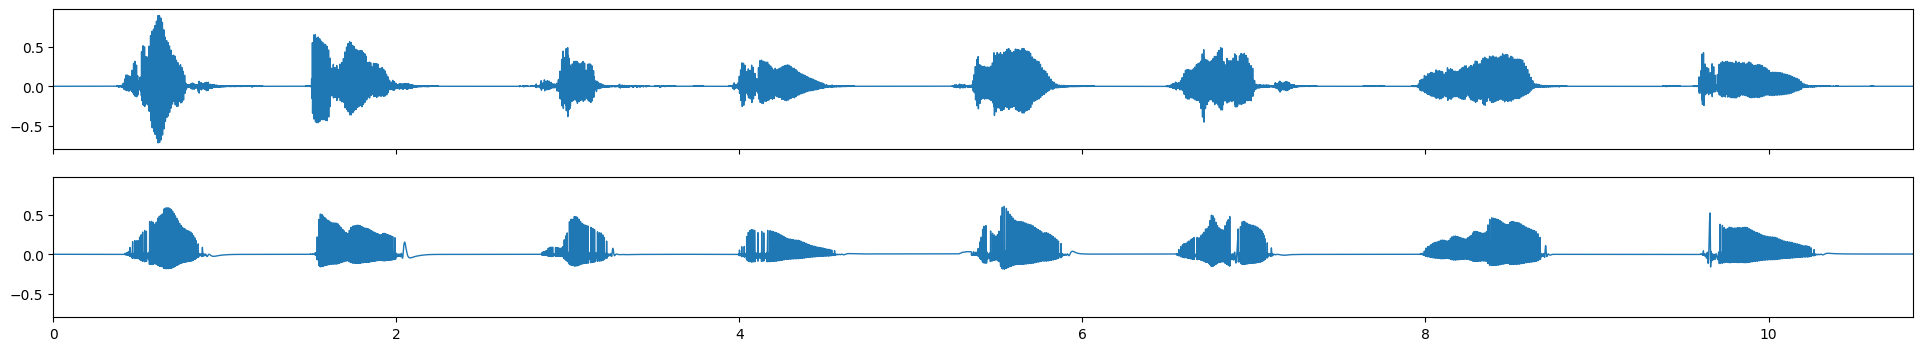

In [111]:
renderjob

In [9]:
renderjob.outfile

'/tmp/csoundengine-nkxyq9u0.wav'